In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set(font_scale=1.5, style='ticks')
import pandas as pd
from scipy.stats import ttest_rel
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
sensor_para = pd.read_csv('GCaMP8_exported_ROIs_s2f_full/GCaMP8s_para.csv')
idx = sensor_para['Type']

In [3]:
hits_label = ['jGCaMP8f', 'jGCaMP8m', 'jGCaMP8s', 'jGCaMP7f', 'XCaMP-Gf']
time_ = np.arange(1001)/1000.

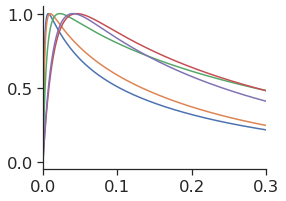

In [4]:
plt.figure(figsize=(4, 3))
for ns, label_ in enumerate(hits_label):
    idx_ =  sensor_para['Type'] & (sensor_para['Cell']==label_)
    para_ = sensor_para[idx_]
    ca_trace_list=[]
    for _, n_para in para_.iterrows():
        tau_r, tau_d1, tau_d2, k = n_para['rise']/1000., n_para['decays']/1000., n_para['decayf']/1000., n_para['weight']
        if tau_d1==0:
            continue
        ca_trace = np.exp(-time_/tau_d1)*(1-np.exp(-time_/(tau_r+1e-6)))
        ca_trace += np.exp(-time_/(tau_d2+1e-6))*(1-np.exp(-time_/(tau_r+1e-6)))*k
        ca_trace_list.append(ca_trace)
    ca_trace_list = np.array(ca_trace_list)
    mean_max = ca_trace_list.mean(axis=0).max()
    ca_trace_list = ca_trace_list/mean_max
    plt.plot(time_, ca_trace_list.mean(axis=0))
# plt.legend()
plt.xlim([0, 0.3])
sns.despine()
plt.show()

## Nonlinearity

In [6]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set(font_scale=1.5, style='ticks')
%load_ext autoreload
%autoreload 2
%matplotlib inline

from spike2calcium_sigmoid_ALS import *

# get cell list information
flist = sorted(glob('GCaMP8_exported_ROIs_s2f_full/fit_als_sigmoid_results_v02/*.npz'))
cell_info=["_".join(os.path.basename(f).split('_')[:6]) for f in flist]
cell_info_uq = np.unique(cell_info)

cell_info=["_".join(os.path.basename(f).split('_')[:2]) for f in flist]
sensors, sensor_idx = np.unique(cell_info, return_inverse=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
num_AP = 20
num_cell = len(cell_info_uq)
dff_resp = np.zeros((num_cell, num_AP+1))
cell_type_list = np.zeros(num_cell).astype('bool')

for n, nf in enumerate(cell_info_uq):
    f_dff = f'GCaMP8_exported_ROIs_s2f_full/dff_v03/{nf}.npz'
    cell_type = np.load(f_dff, allow_pickle=True)['cell_type']
    cell_type_list[n] = cell_type=='pyr'
    
    f_fit = f'GCaMP8_exported_ROIs_s2f_full/fit_als_sigmoid_results_v02/{nf}_fit.npz'
    _=np.load(f_fit, allow_pickle=True)
    param_kernel = _['param_kernel']
    param_model = _['param_model']
    
    if len(param_kernel)==4:
        tau_r, tau_d1, tau_d2, k = param_kernel
    else:
        tau_r, tau_d1 = param_kernel
        k = 0
    ca_trace = np.exp(-time_/tau_d1)*(1-np.exp(-time_/(tau_r+1e-6)))
    if k>0:
        ca_trace += np.exp(-time_/(tau_d2+1e-6))*(1-np.exp(-time_/(tau_r+1e-6)))*k
    sAP_ca = ca_trace.max()
    ca_trace = np.arange(0, num_AP+1)*sAP_ca
    
    num_dat = len(param_model)
    ca_est_n_file = []
    for n_dat in range(num_dat):
        para_ = param_model[n_dat].copy()
        if np.isnan(para_).sum()==0:
            p = para_
            p[-1] = 0
            ca_est = sigmoid(ca_trace, *p)
        else:
            p = para_[:2]
            p[-1] = 0
            ca_est = linear_(ca_trace, p)
        ca_est_n_file.append(ca_est-ca_est[0])
    dff_resp[n] = np.array(ca_est_n_file).mean(axis=0)

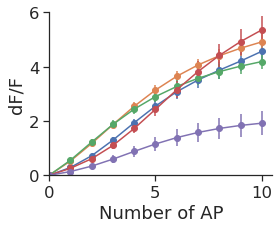

In [9]:
plt.figure(figsize=(4, 3))
sensor_ = sensor_idx[cell_type_list]
dff_resp_ = dff_resp[cell_type_list]

for nsensor in range(5):
    mean_ = dff_resp_[sensor_==nsensor].mean(axis=0)
    sem_ = dff_resp_[sensor_==nsensor].std(axis=0)/np.sqrt((sensor_==nsensor).sum())
    plt.errorbar(np.arange(0, 11), mean_[:11], yerr=sem_[:11], ls='-', marker='o')
sns.despine()
plt.xlabel('Number of AP')
plt.ylabel('dF/F')
plt.xlim([0, 10.5])
plt.ylim([0, 6])
plt.show()

In [16]:
def sigmoid_(x, Fm, Ca0, beta, F0):
    return Fm/(1+np.exp(-(x-Ca0)*beta))+F0

In [17]:
from scipy.optimize import curve_fit

[ 6.1043797   4.17057528  0.39053296 -1.05206667]
[ 7.45464483  2.69111721  0.36000789 -2.07330924]
[ 7.45579182  1.28241713  0.34372099 -2.94651311]
[ 6.84124734  5.5621592   0.42321225 -0.60984574]
[ 2.36379296  3.93607549  0.47166752 -0.32850743]


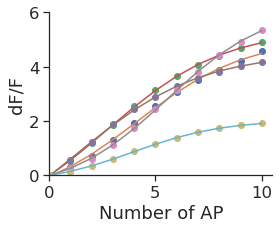

In [22]:
plt.figure(figsize=(4, 3))
sensor_ = sensor_idx[cell_type_list]
dff_resp_ = dff_resp[cell_type_list]

for nsensor in range(5):
    mean_ = dff_resp_[sensor_==nsensor].mean(axis=0)
    plt.plot(np.arange(0, 11), mean_[:11], 'o')
    xdata = np.arange(0, 11)
    ydata = mean_[:11]
    p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    popt, pcov = curve_fit(sigmoid_, xdata, ydata, p0, method='dogbox')
    plt.plot(xdata, sigmoid_(xdata, *popt))
    print(popt)
sns.despine()
plt.xlabel('Number of AP')
plt.ylabel('dF/F')
plt.xlim([0, 10.5])
plt.ylim([0, 6])
plt.show()

### GCaMP6